# Оптимизация производства

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Нам предстоит построить модель, которая предскажет температуру стали.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor, Pool, cv
import lightgbm as lgb

# Шаг 1 Исследование

In [3]:
arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [4]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [5]:
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

In [6]:
#Выделим время нагрева в минутах
arc['delta'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']).dt.total_seconds() / 60
arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,delta
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,3.800000
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,3.083333
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,2.866667
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,6.083333
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,2.466667
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,2.616667
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,3.000000
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,3.066667
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0.950000


Не думаю, что нам пригодится начало нагрева и конец нагрева, быть может есть смысл использовать суммарное время нагрева.

In [7]:
bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [8]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [9]:
bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Аномально больших значений не наблюдается по добавлению легирующих элементов. Конечно не понятно в каких единицах измерения указаны элементы и в каким массовых долях их добавляют, скорее всего мы имеем дело с граммами и мкг. Главным образом массовая доля какого либо из легирующих элементов (ЛЭ) не должна превышать 50%, иначе это уже будет не сплав на основе стали, а на основе этого ЛЭ. Обычно массовая доля ЛЭ не превышает 20-30 % для сильнолегированных сталей и 2.5 % для слаболегированных. В данных отсутствуют аномально высокие значения, которые резко отличаются от других. Может показаться завышенным максимум ЛЭ Bulk 12 (1849) относительно других ЛЭ, но это вполне может быть хром с 10-20 % доли (например сталь 12Х18Н10Т, где хрома 18% - одна из самых распространенных конструкционных сталей).

Пропуски в столбцах *bulk* означают, что элемент не добавлялся, их следует заменить на 0.

In [10]:
bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


In [11]:
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Не думаю, что время добавления ЛЭ нам понадобится. В работе их использовать не будем.

In [12]:
gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [13]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [14]:
gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [15]:
gas['key'].duplicated().sum()

0

Важный этап для получения сплава, на котором происходит дегозация и могут убираться неоднородности. Объем использованного газа может влиять на изменение температуры.

In [16]:
temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [17]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [18]:
temp['Время замера'] = pd.to_datetime(temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

In [19]:
# выделим последню температуру для каждой партии
temp_sort = temp.sort_values(['key', 'Время замера'], ascending=[True, False])
temp_sort

,key,Время замера,Температура
4,1,2019-05-03 11:30:39,1613.0
3,1,2019-05-03 11:30:01,1601.0
2,1,2019-05-03 11:29:11,1618.0
1,1,2019-05-03 11:25:53,1604.0
0,1,2019-05-03 11:16:18,1571.0
...,...,...,...
15906,3241,2019-09-01 04:38:08,NaN
15905,3241,2019-09-01 04:33:42,NaN
15904,3241,2019-09-01 04:22:39,NaN
15903,3241,2019-09-01 04:16:12,NaN


In [20]:
temp_sort = temp_sort.drop_duplicates('key').reset_index(drop=True)
temp_sort

,key,Время замера,Температура
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0
...,...,...,...
3211,3237,2019-08-31 23:05:43,NaN
3212,3238,2019-08-31 23:43:00,NaN
3213,3239,2019-09-01 02:24:15,NaN
3214,3240,2019-09-01 03:35:16,NaN


In [21]:
temp_sort['Температура'].isna().sum()

739

Не все замеры прошли удачно. В некоторых партиях последняя температура отсутствует и таких строк довольно много ~ 23%. Замена пустых значений на среднее приведет к искажению данных, лучше такие строки удалить.

In [22]:
temp_sort.dropna(inplace=True)

In [23]:
temp_sort

,key,Время замера,Температура
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0
...,...,...,...
2472,2495,2019-08-06 00:54:42,1591.0
2473,2496,2019-08-06 01:29:52,1591.0
2474,2497,2019-08-06 01:53:50,1589.0
2475,2498,2019-08-06 02:25:31,1594.0


Найдем начальные температуры.

In [24]:
temp_sort_start = temp.sort_values(['key', 'Время замера'], ascending=True)

In [25]:
temp_sort_start = temp_sort_start.drop_duplicates('key').reset_index(drop=True)

In [26]:
temp_sort_start['Температура'].isna().sum()

0

In [27]:
temp_sort_start.columns = ['key', 'timez', 'temperature_start']

In [28]:
temp_sort_start

,key,timez,temperature_start
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:23:19,1576.0
...,...,...,...
3211,3237,2019-08-31 22:44:04,1569.0
3212,3238,2019-08-31 23:30:31,1584.0
3213,3239,2019-09-01 01:31:47,1598.0
3214,3240,2019-09-01 02:39:01,1617.0


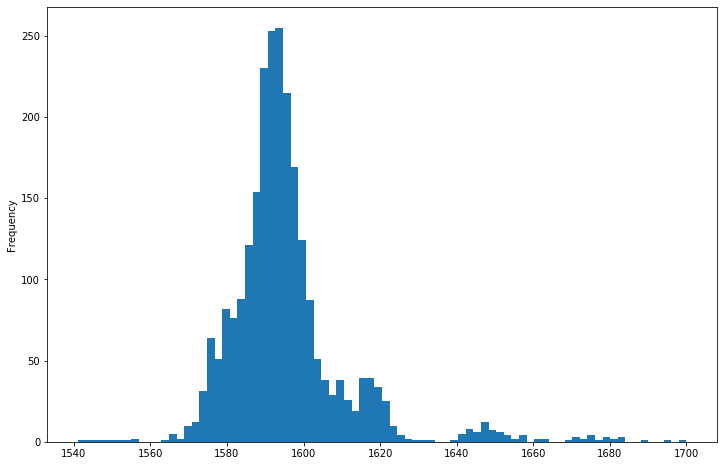

In [29]:
# Распределение температуры
temp_sort['Температура'].plot(kind='hist', figsize=(12,8), bins=80)

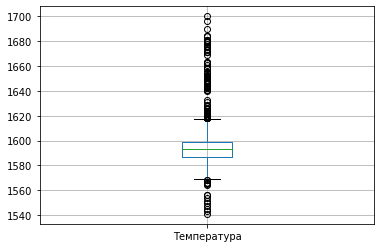

In [30]:
temp_sort.boxplot(column='Температура')

Похоже на нормальное распределение с длиным хвостом вправо.  
Чутка теории. Вообще требуемая температура зависит от состава стали, т.е. от того, какой ЛЭ и в каком количестве добавляется в сплав. Если добавляют более тугоплавкий материал чем сталь, то температура должна быть выше. Если есть основной легирующий элемент, то в первую очередь смотрят на диаграмму состояния сплава (например, Fe-Ni, если основной ЛЭ Ni). В зависимости от количества добавляемого ЛЭ может образовываться другая структура или новое химическое соединение, которые могут иметь свойства отличные от материалов, образующих сплав. Температура плавления новой структуры может быть выше, чем температура плавления стали, поэтому такой сплав нагревают еще больше и выдерживают некоторое время эту температуру, чтобы приблизить сплав к равновесному состоянию. Если двухкомпонентные и в меньшей степени трехкомпонентные сплавы более менее изучены, то свойства многокомпанентных сплавов, диаграммы состояний которых представляют сосбой многомерные системы, предсказывать еще не научились и изучают на практике методом проб и ошибок. Таким образом, использовать в модели данные добавляемых материалов конечно же нужно, а вот время можно выбросить из данных.

In [31]:
wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [33]:
wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Аналогично *bulk*.

In [34]:
wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


*wire_time* в модели использовать не будем.

**Подведем итоги**

target у нас температура из таблицы *temp_sort*,  
features - данные по количеству ЛЭ, газа и возможно мощность. Везде исключаем дату и время.

# Шаг 2 Подготовка данных

In [36]:
# Приведем данные по ЛЭ в *bulk* и *wire* к целочисленному типу и заменим NaN на 0

def int_zero(data):
    for column in data.columns.drop('key'):
        data[column] = data[column].round(0).fillna(0)
    return data

In [37]:
bulk_new = int_zero(bulk)
wire_new = int_zero(wire)

In [38]:
#красиво
bulk_new

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


In [39]:
# Столбец с суммарным количеством всех ЛЭ в партии
bulk_new['bulk_sum'] = bulk_new['Bulk 1'] + bulk_new['Bulk 3'] + bulk_new['Bulk 4'] + bulk_new['Bulk 5'] + bulk_new['Bulk 6'] + bulk_new['Bulk 10'] + bulk_new['Bulk 11'] + bulk_new['Bulk 12'] + bulk_new['Bulk 14'] + bulk_new['Bulk 15']

In [40]:
wire_new['wire_sum'] = wire_new['Wire 1'] + wire_new['Wire 2'] + wire_new['Wire 1'] + wire_new['Wire 3'] + wire_new['Wire 6']

In [41]:
#Данные в таблице gas округлим до трех знаков после запятой
gas['Газ 1'] = gas['Газ 1'].round(3)

In [42]:
temp_sort = temp_sort.merge(temp_sort_start[['temperature_start', 'key']], on='key', how='left')

In [43]:
#Соберем итоговую таблицу для модели
data_for_model = temp_sort[['key', 'Температура', 'temperature_start']].merge(bulk_new, on='key', how='left').merge(wire_new, on='key', how='left').merge(gas, on='key', how='left')

In [44]:
#Найдем суммарную активную и реактивную мощность и время нагрева для каждой партии
arc_pivot = arc.pivot_table(index=['key'], values=['Активная мощность', 'Реактивная мощность', 'delta'], aggfunc=['sum'])

In [45]:
arc_pivot.columns = ['delta_sum', 'active_power_sum', 'reactive_power_sum']

In [46]:
arc_pivot = arc_pivot.round(2)

In [47]:
arc_pivot

,delta_sum,active_power_sum,reactive_power_sum
key,,,
1,18.30,4.88,3.18
2,13.52,3.05,2.00
3,10.92,2.53,1.60
4,12.35,3.21,2.06
5,14.48,3.35,2.25
...,...,...,...
3237,15.15,3.93,2.83
3238,9.10,2.11,1.68
3239,20.27,4.67,3.11


In [48]:
data_for_model = data_for_model.merge(arc_pivot, on='key', how='left')

In [49]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 33 columns):
key                   2477 non-null int64
Температура           2477 non-null float64
temperature_start     2477 non-null float64
Bulk 1                2408 non-null float64
Bulk 2                2408 non-null float64
Bulk 3                2408 non-null float64
Bulk 4                2408 non-null float64
Bulk 5                2408 non-null float64
Bulk 6                2408 non-null float64
Bulk 7                2408 non-null float64
Bulk 8                2408 non-null float64
Bulk 9                2408 non-null float64
Bulk 10               2408 non-null float64
Bulk 11               2408 non-null float64
Bulk 12               2408 non-null float64
Bulk 13               2408 non-null float64
Bulk 14               2408 non-null float64
Bulk 15               2408 non-null float64
bulk_sum              2408 non-null float64
Wire 1                2373 non-null float64
Wire 2         

In [50]:
#Заменим NaN на 0
data_for_model = data_for_model.fillna(0)

In [51]:
data_for_model1 = data_for_model[data_for_model['Газ 1'] != 0]

Есть подозрение, что большое количество нулей в столбцах ЛЭ путает модель при обучении. Уберем столбцы с ЛЭ, которых реже всего добавляют (<30 раз за все партии).

In [52]:
data_for_model1 = data_for_model1.drop(['key', 'Bulk 2', 'Bulk 5', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 13', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 7', 'Wire 8', 'Wire 9'], axis=1)

In [53]:
#Дадим столбцам корректные названия
data_for_model1.columns = ['temperature', 'temperature_start', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15', 'bulk_sum', 'wire_1', 'wire_2', 'wire_6', 'wire_sum', 'gas_1', 'delta_sum', 'active_power_sum', 'reactive_power_sum']

In [54]:
#Число партий, когда легирующие элементы не добавляли
data_for_model1[(data_for_model1['bulk_sum'] == 0) & (data_for_model1['wire_sum'] == 0)]['temperature'].count()

29

In [55]:
#Такие записи нас мало интересуют, либо по этим партиям данные ЛЭ потерялись, при формировании датасета, либо это были пробные партии, т.к. современные стали всегда легируют
data_for_model1 = data_for_model1[(data_for_model1['bulk_sum'] != 0) | (data_for_model1['wire_sum'] != 0)]

Найдем суммарную мощность и уберем реактивную, так как этот столбец будет уже излишним.

In [56]:
data_for_model1['power_sum'] = data_for_model1['active_power_sum'] + data_for_model1['reactive_power_sum']
data_for_model1 = data_for_model1.drop('reactive_power_sum', axis=1)

In [57]:
data_for_model1 = data_for_model1.drop(['bulk_10','bulk_12', 'wire_1', 'delta_sum'], axis=1)

In [58]:
# Итоговая таблица
data_for_model1

,temperature,temperature_start,bulk_1,bulk_3,bulk_4,bulk_6,bulk_11,bulk_14,bulk_15,bulk_sum,wire_2,wire_6,wire_sum,gas_1,active_power_sum,power_sum
0,1613.0,1571.0,0.0,0.0,43.0,0.0,0.0,150.0,154.0,553.0,0.0,0.0,120.0,29.750,4.88,8.06
1,1602.0,1581.0,0.0,0.0,73.0,0.0,0.0,149.0,154.0,582.0,0.0,0.0,192.0,12.556,3.05,5.05
2,1599.0,1596.0,0.0,0.0,34.0,0.0,0.0,152.0,153.0,544.0,0.0,0.0,182.0,28.555,2.53,4.13
3,1625.0,1601.0,0.0,0.0,81.0,0.0,0.0,153.0,154.0,595.0,0.0,0.0,178.0,18.841,3.21,5.27
4,1602.0,1576.0,0.0,0.0,78.0,0.0,0.0,151.0,152.0,584.0,9.0,0.0,187.0,5.414,3.35,5.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,1591.0,1570.0,0.0,21.0,0.0,0.0,0.0,129.0,223.0,719.0,0.0,0.0,178.0,7.126,3.21,5.57
2473,1591.0,1554.0,0.0,0.0,63.0,0.0,0.0,129.0,226.0,796.0,0.0,0.0,228.0,9.413,4.20,7.01
2474,1589.0,1571.0,0.0,0.0,85.0,0.0,0.0,124.0,226.0,665.0,9.0,0.0,197.0,6.272,2.21,4.06
2475,1594.0,1591.0,0.0,90.0,0.0,0.0,0.0,129.0,207.0,733.0,0.0,0.0,236.0,14.954,3.41,5.77


In [59]:
#Разобьем данные на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    data_for_model1.drop('temperature', axis=1), data_for_model1.temperature, test_size=0.25, random_state=12345)

# Шаг 3 Обучение модели

In [60]:
#Обучим модель линейной регрессии
model_reg = LinearRegression()
model_reg.fit(features_train, target_train)
predict_reg = model_reg.predict(features_test)
mean_absolute_error(target_test, predict_reg)

7.520590252748718

In [61]:
#Обучим модель градиентного бустинга из catboost применив кросс-валидацию
pool_cat = Pool(data=features_train,
              label=target_train)

In [62]:
pool_test = Pool(data=features_test, label=target_test)

In [63]:
#Параметры модели
params = {'iterations': 20000,
         'depth': 6,
         'loss_function': 'MAE',
          'learning_rate': 0.005,
         'verbose': 20,
         'random_state': 12345}

In [64]:
#cv(pool_cat, params, fold_count=3, plot=False, as_pandas=True)

In [65]:
params2 = {'iterations': 3000,
         'depth': 12,
         'loss_function': 'MAE',
          'learning_rate': 0.01,
         'verbose': 20,
         'random_state': 12345}

In [66]:
#cv(pool_cat, params2, fold_count=3, plot=False, as_pandas=True)

Обучим модель из LightGBM тоже применив кросс-валидацию.

In [67]:
#Параметры модели
lgb_params = {'metric': 'mae',
              'objective': 'regression',
             'num_boost_round': 20000,
             'stratified': False,
             'random_state': 12345,
             'max_depth': 6,
             'learning_rate': 0.005}

In [68]:
lgb_data_train = lgb.Dataset(features_train, target_train)

In [69]:
#lgb.cv(lgb_params, lgb_data_train, verbose_eval=20)

Протестируем модели.

In [70]:
model_catboost = CatBoostRegressor(iterations=22000,
         depth=4,
         loss_function='MAE',
         learning_rate=0.001,
         verbose=20,
         random_state=12345)

In [71]:
model_catboost.fit(pool_cat)

0:	learn: 9.4926680	total: 48.9ms	remaining: 17m 55s
20:	learn: 9.4508099	total: 173ms	remaining: 3m
40:	learn: 9.4089622	total: 370ms	remaining: 3m 17s
60:	learn: 9.3657212	total: 561ms	remaining: 3m 21s
80:	learn: 9.3255121	total: 842ms	remaining: 3m 47s
100:	learn: 9.2879628	total: 1.04s	remaining: 3m 45s
120:	learn: 9.2468361	total: 1.24s	remaining: 3m 43s
140:	learn: 9.2101144	total: 1.43s	remaining: 3m 42s
160:	learn: 9.1725156	total: 1.63s	remaining: 3m 41s
180:	learn: 9.1348686	total: 1.91s	remaining: 3m 50s
200:	learn: 9.0976984	total: 2.11s	remaining: 3m 48s
220:	learn: 9.0626064	total: 2.31s	remaining: 3m 47s
240:	learn: 9.0282135	total: 2.59s	remaining: 3m 54s
260:	learn: 8.9914967	total: 2.79s	remaining: 3m 52s
280:	learn: 8.9581785	total: 3s	remaining: 3m 51s
300:	learn: 8.9261797	total: 3.2s	remaining: 3m 50s
320:	learn: 8.8963390	total: 3.48s	remaining: 3m 55s
340:	learn: 8.8687315	total: 3.68s	remaining: 3m 53s
360:	learn: 8.8384240	total: 3.96s	remaining: 3m 57s
380:	

In [72]:
predict = model_catboost.predict(pool_test)

In [73]:
mean_absolute_error(target_test, predict)

5.970533590683177

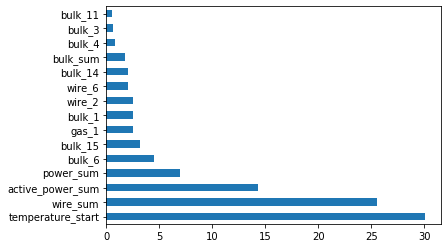

In [74]:
# Важность признаков
feat_importances = pd.Series(model_catboost.feature_importances_, index=features_test.columns)
feat_importances.nlargest(20).plot(kind='barh')

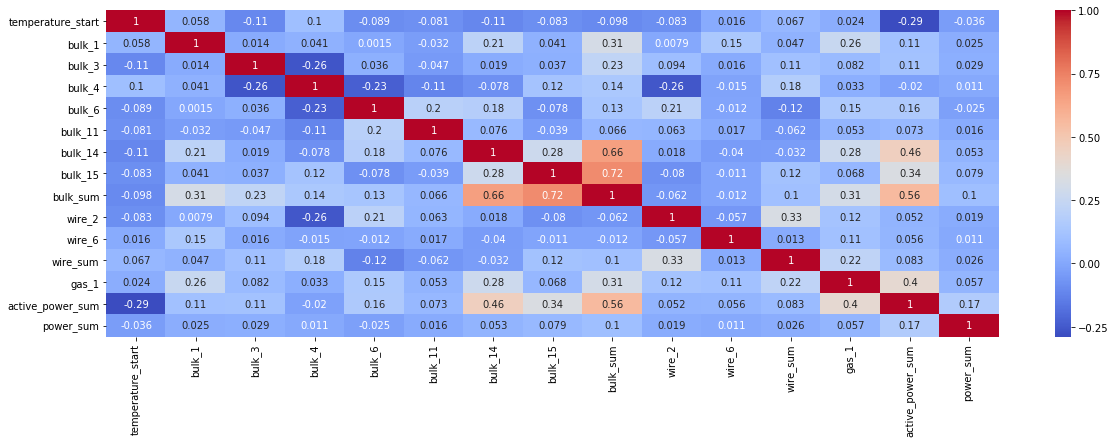

In [75]:
# Матрица корреляций
# уже Убрал столбцы bulk12, delta_sum и wire_1
plt.figure(figsize = (20,6))
ax = sns.heatmap(features_train.corr(), annot=True, cmap='coolwarm')

In [77]:
lgb_params_test = {'metric': 'mae',
              'objective': 'regression',
             'stratified': False,
             'random_state': 12345,
             'max_depth': 6,
             'learning_rate': 0.001}

In [78]:
%%time
bst = lgb.train(lgb_params_test, lgb_data_train, num_boost_round=20000)

CPU times: user 18min 32s, sys: 9.27 s, total: 18min 42s
Wall time: 18min 51s


In [79]:
predictions_lgb = bst.predict(features_test, num_iteration=bst.best_iteration)

In [80]:
mean_absolute_error(target_test, predictions_lgb)

6.3548738904830415

Самая низкая MAE получилась у catboost: 5.97

# Отчет

Не все конечные значения температуры присутствуют в данных. Скорее всего это производственные сложности, связанные с ошибкой измерения или отказом прибора. Разброс конечных температур может припятствовать получению более низкой метрики, но фильтрация данных, выходящих за границы графика boxplot и уменьшение разброса будет неправильным решением. Разброс измерений зависит не только от метода измерения, на него также влияет разнообразие факторов самого производства. Плюс, как я писал уже выше, на требуемою конечную температуру сплава влияют легирующие элементы, которые сдвигают эту температуру в ту или иную сторону.  

Самым важным фактором для модели является начальная температура. Поэтому можно поставить смежную задачу по увеличению точности измерения температуры на производстве.  

Также видно, что используют разный состав стали в различных партиях. Одни элементы добавляют в сталь крайне редко, другие почти во все партии. В реальной задачи по хорошему надо значть хим. сотав стали и требуемый состав. И оптимизировать производство для получения определенного сотава стали, а тут явно с ним эксперементировали.

Итоговая модель: catboost с параметрами `iterations=22000, depth=4 и learning_rate=0.001`. MAE = 5.97.